In [1]:
import os
import re
import cv2
import time
import glob
import json
import open3d
import numpy as np
import matplotlib.pyplot as plt

import utils.pointcloud as pointcloud
import utils.fread as fread
import utils.registration as registration

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def read_result(result_file, threshold=0.5):
    data = np.load(result_file)

    points = data["points"]
    bboxes = data["bboxes"]
    labels = data["labels"]
    scores = data["scores"]

    indices = np.argwhere(scores < threshold).flatten()

    bboxes = np.delete(bboxes, indices, axis=0)
    labels = np.delete(labels, indices, axis=0)
    scores = np.delete(scores, indices, axis=0)
    return points, bboxes, labels, scores

In [3]:
def get_bboxes(bboxes, center_mode='lidar_bottom', rot_axis=2):
    bboxes_pcds = []

    for i in range(len(bboxes)):
        center = bboxes[i, 0:3]
        dim = bboxes[i, 3:6]
        yaw = np.zeros(3)
        yaw[rot_axis] = bboxes[i, 6]
        rot_mat = open3d.geometry.get_rotation_matrix_from_xyz(yaw)
        
        if center_mode == 'lidar_bottom':
            # bottom center to gravity center
            center[rot_axis] += dim[rot_axis] / 2
        elif center_mode == 'camera_bottom':
            # bottom center to gravity center
            center[rot_axis] -= dim[rot_axis] / 2
        
        box3d = open3d.geometry.OrientedBoundingBox(center, rot_mat, dim)

        line_set = open3d.geometry.LineSet.create_from_oriented_bounding_box(box3d)
        line_set.paint_uniform_color([1, 0.706, 0])
        bboxes_pcds.append(line_set)
        
        # line_set.paint_uniform_color([1, 0.706, 0])
        # draw bboxes on visualizer
        # self.o3d_vis.add_geometry(line_set)

        # # change the color of points which are in box
        # if self.pcd is not None and mode == 'xyz':
        #     indices = box3d.get_point_indices_within_bounding_box(
        #         self.pcd.points)
        #     self.points_colors[indices] = np.array(bbox_color[i]) / 255.
    return bboxes_pcds

In [4]:
voxel_size = 0.03
results_dir = f"data/inference_results/h3dnet_3x8_scannet/{voxel_size}/intel_l515/exp_3"

result_files = glob.glob(os.path.join(results_dir, "*.npz"))

In [6]:
for i in range(len(result_files)):
    points, bboxes, labels, scores = read_result(result_files[i])

    print(f"Number of bboxes: {len(bboxes)}")
    
    if len(bboxes) == 0:
        continue

    pcd = pointcloud.make_pcd(points[:, :3])

    bbox_meshes = get_bboxes(bboxes)

    open3d.visualization.draw_geometries([pcd, *bbox_meshes])

Number of bboxes: 1
Number of bboxes: 2
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
Number of bboxes: 2
Number of bboxes: 5
Number of bboxes: 4
Number of bboxes: 5
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
Number of bboxes: 4
Number of bboxes: 5
Number of bboxes: 3
Number of bboxes: 4
Number of bboxes: 4
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
Number of bboxes: 3
Number of bboxes: 2
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
Number of bboxes: 5
Number of bboxes: 4
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
Number of bboxes: 4
Number of bboxes: 3
Number of bboxes: 4
Number of bboxes: 4
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
Number of bboxes: 3
Number of bboxes: 4
Number of bboxes: 5
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
Number of bboxes: 6
Number of bboxes: 4
Number of bboxes

In [8]:
voxel_size = 0.03
results_dir = f"data/inference_results/pointnet2_ssg_2xb16/{voxel_size}/intel_l515/exp_3"

result_files = glob.glob(os.path.join(results_dir, "*.npz"))

for i in range(len(result_files)):
    data = np.load(result_files[i])

    points = data["points"]
    mask = data["mask"]

    color_pallete = [pointcloud.random_color() for _ in range(mask.max() + 1)]

    colors = [color_pallete[i] for i in mask]
    
    pcd = pointcloud.make_pcd(points)
    pcd.colors = open3d.utility.Vector3dVector(colors)
    
    pointcloud.view(pcd)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [4]:
data = np.load("temp/sample_segmentation.npz")

points = data["points"]
mask = data["mask"]

color_pallete = [pointcloud.random_color() for _ in range(mask.max() + 1)]

colors = [color_pallete[i] for i in mask]

In [5]:
pcd = pointcloud.make_pcd(points)
pcd.colors = open3d.utility.Vector3dVector(colors)

In [6]:
pointcloud.view(pcd)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [23]:
img = open3d.io.read_image("data/raw_data/intel_l515/exp_3/frame-1691638753488.depth.png")
intrinsic = open3d.camera.PinholeCameraIntrinsic(640, 480, 603.1535, 603.2016, 328.1711, 245.9775)

img = open3d.geometry.Image(np.random.randint(0, 2**16, (640, 480), dtype=np.uint16))

pcd = open3d.geometry.PointCloud.create_from_depth_image(img, intrinsic, depth_scale=4000.0, stride=1)
pointcloud.view(pcd)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [2]:
def read_labels(fname):
    with open(fname) as f:
        data = json.load(f)
    return data


def get_oriented_bounding_boxes(fname):
    labels = read_labels(fname)
    bboxes = []
    
    for obj in labels.get("objects"):
        center = list(obj.get("centroid").values())
        dimensions = list(obj.get("dimensions").values())
        rotations = list(obj.get("rotations").values())

        rot_mat = open3d.geometry.get_rotation_matrix_from_xyz(rotations)
        box3d = open3d.geometry.OrientedBoundingBox(center, rot_mat, dimensions)
        bboxes.append(box3d)
    
    return bboxes

def get_bounding_boxes(fname):
    labels = read_labels(fname)
    bboxes = []
    
    for obj in labels.get("objects"):
        center = list(obj.get("centroid").values())
        dimensions = list(obj.get("dimensions").values())
        rotations = list(obj.get("rotations").values())

        rot_mat = open3d.geometry.get_rotation_matrix_from_xyz(rotations)
        box3d = open3d.geometry.OrientedBoundingBox(center, rot_mat, dimensions)
        bbox = open3d.geometry.LineSet.create_from_oriented_bounding_box(box3d)
        # bbox.paint_uniform_color([1, 0.706, 0])
        bboxes.append(bbox)
    
    return bboxes

In [3]:
def read_intrinsics(filename: str) -> (float, open3d.camera.PinholeCameraIntrinsic):
    with open(filename, "r") as f:
        metadata = json.load(f)
        depth_scale = metadata["depth_scale"]
        intrinsics = open3d.camera.PinholeCameraIntrinsic(
            metadata["width"],
            metadata["height"],
            metadata["fx"],
            metadata["fy"],
            metadata["px"],
            metadata["py"]
        )
        
        return depth_scale, intrinsics

In [13]:
def read_pcd(fname: str, intrinsics: open3d.camera.PinholeCameraIntrinsic, depth_scale: float) -> open3d.geometry.PointCloud:
    depth_image = open3d.io.read_image(fname)
    return open3d.geometry.PointCloud.create_from_depth_image(depth_image, intrinsics, depth_scale=depth_scale)


def calc_obj_std(obj: open3d.geometry.PointCloud) -> float:
    pts = np.asarray(obj.points)
    if len(pts) == 0:
        return 0
    
    center = np.mean(pts, axis=0)
    distances = np.linalg.norm(pts - center, axis=1)
    return np.std(distances)

In [5]:
def calc_sequence_pts_std(
    sequence_dir: str,
    oriented_bboxes: list,
    intrinsics: open3d.camera.PinholeCameraIntrinsic,
    depth_scale: float,
    limit: int = 0,
    object_id: int = 0,
) -> (list, float) :
    
    sequence_ts = fread.get_timstamps_from_images(sequence_dir, ext=".depth.png")
    
    if limit > 0:
        limit = min(limit, len(sequence_ts))
        sequence_ts = sequence_ts[:limit]
    
    stds = []

    for t in range(len(sequence_ts)):
        fname = os.path.join(sequence_dir, f'frame-{sequence_ts[t]}.depth.png')
        pcd = read_pcd(fname, intrinsics, depth_scale)
        obj = pcd.crop(oriented_bboxes[object_id])
        s = calc_obj_std(obj)
        stds.append(s)
        
    return sequence_ts, stds

In [87]:
pcd_files = glob.glob(f"data/label-cloud/pointclouds/*.pcd")

for pcd_file in pcd_files:
    label_file = pcd_file.replace('.pcd', '.json').replace("pointclouds", "labels")
    
    bboxes = get_bounding_boxes(label_file)    
    # pcd = open3d.io.read_point_cloud(pcd_file)
    # open3d.visualization.draw_geometries([pcd, *bboxes])
    
    # oriented_bboxes = get_oriented_bounding_boxes(label_file)
    # x = pcd.crop(oriented_bboxes[0])
    # open3d.visualization.draw_geometries([x])

[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to

In [163]:
fname = os.path.basename(label_file)
trial = re.search('trial_\d', fname).group(0)
subject = re.search('subject-\d', fname).group(0)
sequence = re.search('\d\d', fname).group(0)

sequence_dir = os.path.join(f"data/raw_data/intel_l515/exp_2/{trial}/secondary/{subject}/{sequence}/frames")

bboxes = get_bounding_boxes(label_file)

image_file = glob.glob(os.path.join(sequence_dir, '*.color.png'))[0]

In [8]:
depth_scale, intrinsics = read_intrinsics("data/raw_data/intel_l515/exp_1/metadata/device-1-aligned.json")

In [6]:
def plot_bboxes_on_image(img, bboxes, K):
    for bbox in bboxes:
        lines = np.asarray(bbox.lines)
        vertices = np.asarray(bbox.points)

        vertices_projected_homogeneous = np.dot(K, vertices.T)
        vertices_projected = vertices_projected_homogeneous[:2] / vertices_projected_homogeneous[2]
        vertices_projected = vertices_projected.T.astype(np.int32)
        
        for line in lines:
            cv2.line(img, tuple(vertices_projected[line[0]]), tuple(vertices_projected[line[1]]), (0, 0, 255), 2)
    
    return img    


def plot_std_with_current_frame(stdss, labels, frame_id, output_img=True):
    figure, ax = plt.subplots(1, 1, figsize=(640/100, 480/100), dpi=100)

    for std, label in zip(stdss, labels):
        ax.plot(std, label=label)
        
    # ax.plot(stds)
    ax.axvline(frame_id, color='red', linewidth=1)
    ax.set_xlabel('Frame ID')
    ax.set_ylabel('Depth Standard Deviation (m)')
    ax.legend()
    
    if output_img:
        plt.close(figure)

        figure.canvas.draw()
        image = np.array(figure.canvas.renderer.buffer_rgba())
        # convert rgb to bgr
        image = cv2.cvtColor(image[:, :, :3], cv2.COLOR_RGB2BGR)
        
        return image

In [168]:
img = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
img = plot_bboxes_on_image(img, bboxes, intrinsics.intrinsic_matrix)

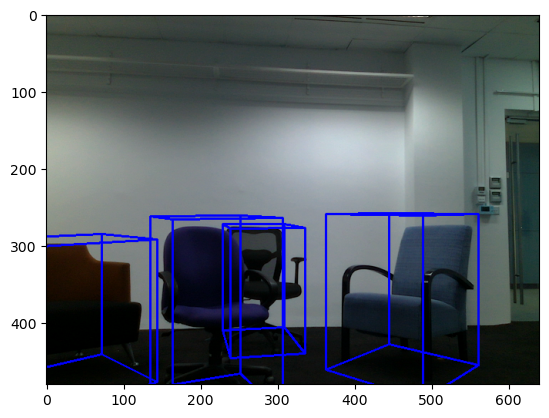

In [169]:
plt.imshow(img)

Text(0, 0.5, 'Depth Standard Deviation (m)')

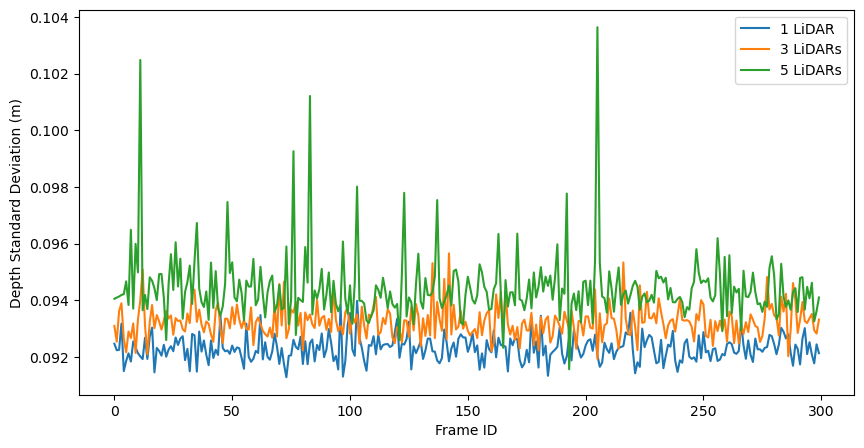

In [111]:
sequence_map = {
    1: "1 LiDAR",
    2: "3 LiDARs",
    3: "5 LiDARs"
}

plt.figure(figsize=(10, 5))

for k, v in sequence_map.items():
    sequence_dir = f"data/raw_data/intel_l515/exp_2/trial_2/secondary/subject-1/{k:02d}/frames"
    
    oriented_bboxes = get_oriented_bounding_boxes(f"data/label-cloud/labels/trial_2_subject-1_{k:02d}.json")

    sequence_ts, stds = calc_sequence_pts_std(sequence_dir, oriented_bboxes, intrinsics, depth_scale, 300)
    
    plt.plot(stds, label=v)
    
plt.legend()
plt.xlabel("Frame ID")
plt.ylabel("Depth Standard Deviation (m)")

In [66]:
# stds: [label, num_objects, num_frames]
def plot_std_with_current_frame(stdss, labels, num_objects, frame_id, output_img=True):
    figure, axs = plt.subplots(ncols=1, nrows=num_objects, figsize=(640/100, 480/100), dpi=100, sharex=True)

    
    for l, label in enumerate(labels):
        for obj_id in range(num_objects):
            axs[obj_id].plot(stdss[l][obj_id], label=label)
    
    for obj_id in range(num_objects):
        axs[obj_id].axvline(frame_id, color='red', linewidth=1)
        axs[obj_id].set_title(f"Object {obj_id}")
        # axs[obj_id].legend()
        
    figure.supxlabel('Frame ID')
    figure.supylabel('Depth Standard Deviation (m)')
    
    handles, labels = axs[0].get_legend_handles_labels()
    figure.legend(handles, labels, loc='upper center', ncol=len(labels))
    
    if output_img:
        plt.close(figure)

        figure.canvas.draw()
        image = np.array(figure.canvas.renderer.buffer_rgba())
        # convert rgb to bgr
        image = cv2.cvtColor(image[:, :, :3], cv2.COLOR_RGB2BGR)
        
        return image
    

def plot_bboxes_on_image(img, bboxes, K):
    for obj_id, bbox in enumerate(bboxes):
        lines = np.asarray(bbox.lines)
        vertices = np.asarray(bbox.points)

        vertices_projected_homogeneous = np.dot(K, vertices.T)
        vertices_projected = vertices_projected_homogeneous[:2] / vertices_projected_homogeneous[2]
        vertices_projected = vertices_projected.T.astype(np.int32)
        
        for line in lines:
            cv2.line(img, tuple(vertices_projected[line[0]]), tuple(vertices_projected[line[1]]), (0, 0, 255), 2)
            
        center = tuple(np.mean(vertices_projected, axis=0).astype(np.int32))
        cv2.putText(img, f"Object {obj_id}", center, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
    return img    

In [67]:
sequence_map = {
    1: "1_LiDAR",
    3: "5_LiDARs"
}

for trial in [3, 4]:

    stdss = []
    labels = []

    for k, v in sequence_map.items():
        sequence_dir = f"data/raw_data/intel_l515/exp_2/trial_{trial}/secondary/subject-1/{k:02d}/frames"
        
        oriented_bboxes = get_oriented_bounding_boxes(f"data/label-cloud/labels/trial_{trial}_subject-1_{k:02d}.json")
        
        obj_stdss = []
        
        for obj_id in range(len(oriented_bboxes)):
            sequence_ts, stds = calc_sequence_pts_std(sequence_dir, oriented_bboxes, intrinsics, depth_scale, 300, obj_id)
            obj_stdss.append(stds)
        
        stdss.append(obj_stdss)
        labels.append(v)
    
    bboxes = get_bounding_boxes(f"data/label-cloud/labels/trial_{trial}_subject-1_{k:02d}.json")

    images = []

    for i, t in enumerate(sequence_ts):
        img = cv2.imread(os.path.join(sequence_dir, f"frame-{t}.depth.png"), cv2.IMREAD_ANYDEPTH)
        img = img / (9 * 4000)
        img = img * 255
        img = np.where(img > 255, 255, img)
        img = np.array(img, dtype=np.uint8)
        img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
        
        img = plot_bboxes_on_image(img, bboxes, intrinsics.intrinsic_matrix)
        
        std_plot = plot_std_with_current_frame(stdss, labels, len(stdss[0]), i, True)
        img = np.hstack((img, std_plot))
        
        images.append(img)
        

    video = cv2.VideoWriter(f"data/videos/bounding_boxes/exp_2_trial_{trial}_{labels[0]}_vs_{labels[1]}.avi", cv2.VideoWriter_fourcc(*'XVID'), 30, (640 * 2, 480))
    for image in images:
        video.write(image)
        
    video.release()

Text(0, 0.5, 'Depth Standard Deviation (m)')

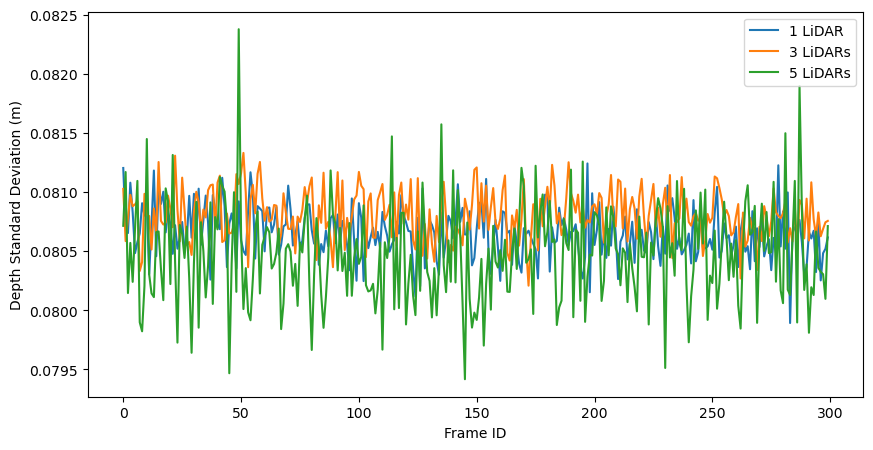

In [75]:
sequence_map = {
    1: "1 LiDAR",
    2: "3 LiDARs",
    3: "5 LiDARs"
}

plt.figure(figsize=(10, 5))

for k, v in sequence_map.items():
    sequence_dir = f"data/raw_data/intel_l515/exp_2/trial_3/secondary/subject-1/{k:02d}/frames"
    
    oriented_bboxes = get_oriented_bounding_boxes(f"data/label-cloud/labels/trial_3_subject-1_{k:02d}.json")

    sequence_ts, stds = calc_sequence_pts_std(sequence_dir, oriented_bboxes, intrinsics, depth_scale, 300, 2)
    
    plt.plot(stds, label=v)
    
plt.legend()
plt.xlabel("Frame ID")
plt.ylabel("Depth Standard Deviation (m)")

Text(0, 0.5, 'Depth Standard Deviation (m)')

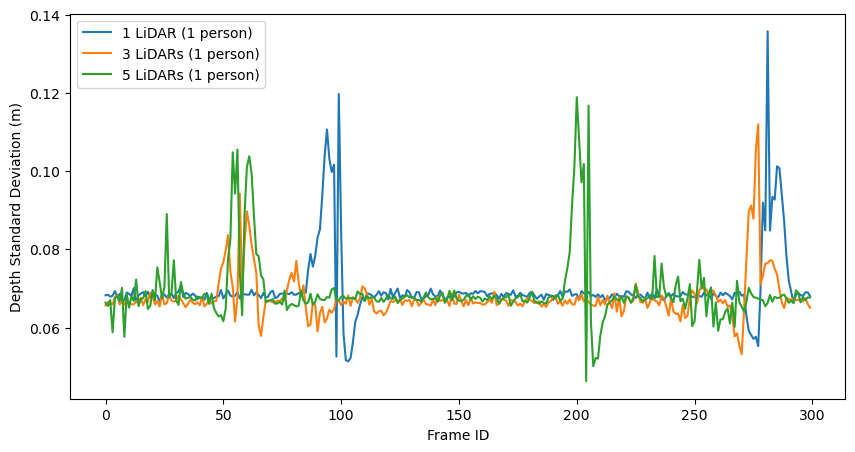

In [76]:
sequence_map = {
    1: "1 LiDAR (1 person)",
    2: "3 LiDARs (1 person)",
    3: "5 LiDARs (1 person)",
    # 4: "5 LiDARs (2 persons)",
}

plt.figure(figsize=(10, 5))

for k, v in sequence_map.items():
    sequence_dir = f"data/raw_data/intel_l515/exp_2/trial_4/secondary/subject-1/{k:02d}/frames"
    
    oriented_bboxes = get_oriented_bounding_boxes(f"data/label-cloud/labels/trial_4_subject-1_{k:02d}.json")

    sequence_ts, stds = calc_sequence_pts_std(sequence_dir, oriented_bboxes, intrinsics, depth_scale, 300, 0)
    
    plt.plot(stds, label=v)
    
plt.legend()
plt.xlabel("Frame ID")
plt.ylabel("Depth Standard Deviation (m)")

In [90]:
k = 1

vis = open3d.visualization.Visualizer()
vis.create_window()

sequence_dir = f"data/raw_data/intel_l515/exp_2/trial_4/secondary/subject-1/{k:02d}/frames"
sequence_ts = fread.get_timstamps_from_images(sequence_dir, ext=".depth.png")
oriented_bboxes = get_oriented_bounding_boxes(f"data/label-cloud/labels/trial_4_subject-1_{k:02d}.json")
    
for t in range(len(sequence_ts)):
    fname = os.path.join(sequence_dir, f'frame-{sequence_ts[t]}.depth.png')
    pcd = read_pcd(fname, intrinsics, depth_scale)
    obj = pcd.crop(oriented_bboxes[0])
    
    vis.update_geometry(obj)
    vis.poll_events()
    vis.update_renderer()
        
    # time.sleep(0.1)

vis.destroy_window()

In [92]:
pointcloud.view(obj)

In [80]:
vis.destroy_window()

Arducam point clouds

In [25]:
import cv2
from utils.depth_camera import DepthCamera

In [35]:
depth_scale, intrinsics = read_intrinsics("data/raw_data/arducam_tof/arducam_tof.json")
depth_img = cv2.imread("data/raw_data/arducam_tof/exp_2/trial_1/camera_2/frame-1690429916921395125.png", cv2.IMREAD_UNCHANGED)

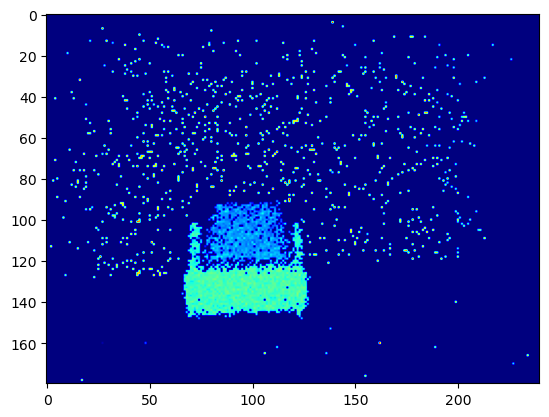

In [38]:
plt.imshow(depth_img, cmap='jet')

In [31]:
arducam = DepthCamera("arducam", "data/raw_data/arducam_tof/arducam_tof.json")
pcd = arducam.depth_to_point_cloud("data/raw_data/arducam_tof/exp_2/trial_1/camera_2/frame-1690429916921395125.png")

In [53]:
fx, fy = intrinsics.get_focal_length()
cx, cy = intrinsics.get_principal_point()

z = 4 * (1 - depth_img / 255)

x, y = np.meshgrid(np.arange(0, z.shape[1]), np.arange(0, z.shape[0]))
x = (x - cx) * z / fx
y = (y - cy) * z / fy

xyz = np.stack([x, y, z], axis=2)
# xyz = xyz[z > 0]
# xyz = xyz.reshape(-1, 3).astype(np.float16)
xyz = np.reshape(xyz, (-1, 3))

xpcd = open3d.geometry.PointCloud()
xpcd.points = open3d.utility.Vector3dVector(xyz)

In [54]:
pointcloud.view(xpcd)

In [58]:
# visualizing the cropped objects

# vis = open3d.visualization.Visualizer()
# vis.create_window()

# vis.add_geometry(xpcd)

vis.destroy_window()

In [55]:
from open3d import JVisualizer

ImportError: cannot import name 'JVisualizer' from 'open3d' (c:\Users\darshanakg.2021\Anaconda3\envs\local-reg\lib\site-packages\open3d\__init__.py)